# Airline Twitter Sentiment Analysis Supervised Machine Learning

In this notebook I aim to use ML to train a classifier to predict a tweet's sentiment so that we can improve an airline's standing by giving appropriate feedback. From this feedback, the airline can make decisions to improve their business model and to improve customer satisfactory.

In [20]:
import pandas as pd
import re
import emoji
import nltk
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



In [21]:
# Download required NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\gauti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Dataset Import/Analysis:
In the following cell I have simply imported the dataset locally and gathered some basic information. Here, it is important to note the column names and the overall structure of the dataset

In [22]:
df = pd.read_csv('data/Tweets.csv')

df.info()

df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


# Sentiment bar chart:

This chart simply represents the values found in the sentiment column along with the total values of each. From this we can see the average sentiment being negative.

<Axes: title={'center': 'Sentiment Distribution'}, xlabel='airline_sentiment'>

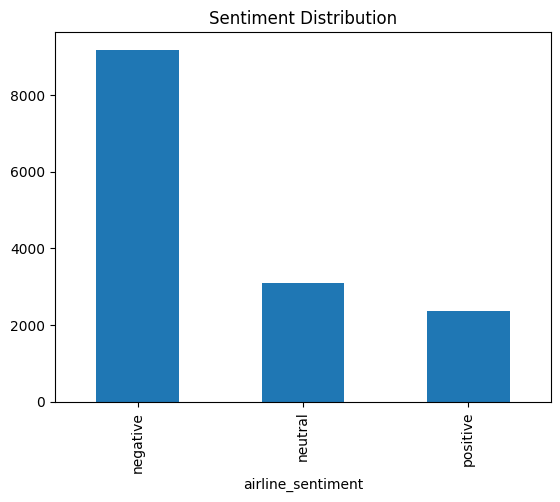

In [23]:
df['airline_sentiment'].value_counts().plot(kind='bar', title='Sentiment Distribution')

# Text Preprocessing:

Here we will prepare the text for sentiment analysis. We will be using the emoji, re, and nltk libraries to accomplish this goal as simply as possible. Each tweet will be converted to complete lowercase, all urls will be removed, emojis will return to their text form (i.e. "laughing_crying_face), and all puncuation will be removed. 

In [24]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower() #Converts all text to lower case
    
    text = emoji.demojize(text) #Converts emojis into text form (i.e. "laughing_crying_face)

    text = re.sub(r"http\S+|@\w+", '', text) #Removes all URLs from tweets
    
    text = re.sub(r'[^a-zA-Z0-9\s:]', '', text) #Removes all puncuation
    
    tokens = word_tokenize(text) #Seperates text based on spaces (i.e ['This', 'is', 'what', 'a', 'tokenized', 'sentence', 'is'])

    processed_text = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] #Reduces words into base root form like converting "running" to "run" or "better" to "good."
    
    return ' '.join(processed_text) #Join all the text back together

df['cleaned_text'] = df['text'].apply(preprocess_text)

print(df[['text', 'cleaned_text']])


                                                    text  \
0                    @VirginAmerica What @dhepburn said.   
1      @VirginAmerica plus you've added commercials t...   
2      @VirginAmerica I didn't today... Must mean I n...   
3      @VirginAmerica it's really aggressive to blast...   
4      @VirginAmerica and it's a really big bad thing...   
...                                                  ...   
14635  @AmericanAir thank you we got on a different f...   
14636  @AmericanAir leaving over 20 minutes Late Flig...   
14637  @AmericanAir Please bring American Airlines to...   
14638  @AmericanAir you have my money, you change my ...   
14639  @AmericanAir we have 8 ppl so we need 2 know h...   

                                            cleaned_text  
0                                                   said  
1           plus youve added commercial experience tacky  
2           didnt today must mean need take another trip  
3      really aggressive blast obnoxious en

# Column Drops and Null Removal

In the following cells, I will determine the columns to keep and the columns to drop. I will also check which columns have null values and fill them with null placeholders.

In [25]:
missing_values = df.isnull().sum()
print(missing_values)

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
cleaned_text                        0
dtype: int64


In [26]:
df.drop(columns=['airline_sentiment_gold', 'negativereason_gold', 'tweet_coord', 'tweet_location', 'user_timezone'], inplace=True) #Drops unnecessary columns

#Fills empty columns with unknown or 0
df['negativereason'].fillna('unknown', inplace=True)  
df['negativereason_confidence'].fillna(0, inplace=True) 

print(df.isnull().sum())

tweet_id                        0
airline_sentiment               0
airline_sentiment_confidence    0
negativereason                  0
negativereason_confidence       0
airline                         0
name                            0
retweet_count                   0
text                            0
tweet_created                   0
cleaned_text                    0
dtype: int64


C:\Users\gauti\AppData\Local\Temp\ipykernel_22368\526532738.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['negativereason'].fillna('unknown', inplace=True)
C:\Users\gauti\AppData\Local\Temp\ipykernel_22368\526532738.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For e

# Sentiment Label Encoding
This code cell simply encodes the sentiment as either a 0, 1, or 2. (0 being negative, 1 being nuetral, and 2 being positive)

In [27]:
le = LabelEncoder()
df['sentiment_encoded'] = le.fit_transform(df['airline_sentiment']) #Converts 'positive' or 'negative' values into either a '1' or a '0'
print(df['airline_sentiment'].head())
print(df['sentiment_encoded'].head())

0     neutral
1    positive
2     neutral
3    negative
4    negative
Name: airline_sentiment, dtype: object
0    1
1    2
2    1
3    0
4    0
Name: sentiment_encoded, dtype: int32


# Vectorization and Splitting
The code vectorizes the cleaned text to be trained on and then I use the train/test split function from the sklearn library to have a 80% train test split.

In [28]:
vectorizer = TfidfVectorizer(max_features=5000) 
X = vectorizer.fit_transform(df['cleaned_text']) #Converts text into numerical vectors for the model
y = df['sentiment_encoded']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Finding the Right Model
The following two cels fits the data on three different base models to achieve the highest score possible. From the results we note that while the score difference isn't significant, SVC overall achieved higher scores on average.

In [29]:
# Fits SVC Model

svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

# Fits Linear Regression Model

lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Fits Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
# Predicts SVC Model
svc_y_pred = svc_model.predict(X_test)
print(classification_report(y_test, svc_y_pred))

# Predicts Linear Regression Model
lr_y_pred = lr_model.predict(X_test)
print(classification_report(y_test, lr_y_pred))

# Predicts Random Forest Model
rf_y_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1889
           1       0.65      0.49      0.56       580
           2       0.80      0.65      0.72       459

    accuracy                           0.80      2928
   macro avg       0.76      0.69      0.72      2928
weighted avg       0.79      0.80      0.79      2928

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      1889
           1       0.67      0.48      0.56       580
           2       0.82      0.61      0.70       459

    accuracy                           0.80      2928
   macro avg       0.77      0.68      0.71      2928
weighted avg       0.79      0.80      0.79      2928

              precision    recall  f1-score   support

           0       0.81      0.92      0.86      1889
           1       0.64      0.46      0.54       580
           2       0.75      0.58      0.65       459

    accuracy        

# Tuning
After I chose the model I wish to use now I can do some fine tuning to achieve a higher score. In the interest of time I simply went with a gridsearch method to find the best C and gamma combinations for my SVC model. This cell alone takes 6minutes to run on average due to the data size but from the results I have found that the default settings seem to achive the best results.

In [31]:
# Param grid is a simple grid search for finding thebest C and gamma combination.

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']  # You can change this to 'linear' or other kernels if needed
}

# Create a GridSearchCV object
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)

# Fit the model
grid.fit(X_train, y_train)

# Display the best parameters
print("Best Parameters found by GridSearch:")
print(grid.best_params_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   5.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   4.8s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.5s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   5.5s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   5.2s
[CV] END ......................C=0.1, gamma=0.01

# Final Model
Plugging in the values from the previous cell we get a final accuracy of 0.806693989071038. Which, while isnt the highest score, is reasonable for the dataset and the amount of tuning done.

In [32]:
#Fits the final model using the above mentioned parameters
best_params = grid.best_params_
final_model = SVC(C=best_params['C'], gamma=best_params['gamma'])
final_model.fit(X_train, y_train)

y_pred = final_model.predict(X_test)

# Print evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.8066939890710383
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      1889
           1       0.68      0.52      0.59       580
           2       0.79      0.68      0.73       459

    accuracy                           0.81      2928
   macro avg       0.77      0.71      0.73      2928
weighted avg       0.80      0.81      0.80      2928



# Testing the model
This cell is simply a test cell to see how well the model does on some test tweets. Based on the results it appears to be working correctly.

In [33]:
new_tweets = ["This airline is fantastic! 😊", "I had a terrible experience."]
new_tweets_transformed = vectorizer.transform(new_tweets)
predictions = final_model.predict(new_tweets_transformed)

for tweet, sentiment in zip(new_tweets, predictions):
    print(f'Tweet: "{tweet}" | Predicted Sentiment: {sentiment}')

Tweet: "This airline is fantastic! 😊" | Predicted Sentiment: 2
Tweet: "I had a terrible experience." | Predicted Sentiment: 0


# Conclution and Final Thoughts
The sentiment analysis model I fit could be drastically improved with more fine tuning; at this point I am trying to keep the notebook simple in the interest of time. I had a couple of ideas for how to make the model run more efficient and achive a higher score though.

-- First would be introducing a second model to handle just the emoji analysis. In my model I decided to simply convert the emojis back to token text, for my case it was fine but for a model trying to achieve near perfect accuracy this could really distort the data if emojis in the tweet were either misinturpreted or converted incorrectly. Adding a second ML to handel the sentiment of the emojis would then allow me to have them be essentially weights for each tweet, where I could adjust the paramaters accordingly.

-- I also wanted to address some of the issues with efficency. I really wanted to explore other models and tuning avenues to achieve the highest base score possible since I did the bare minimum in data cleaning and prepping. 


Overall the model performing at 81% is enough to at least help give a better understanding as to what kind of tweets would be constructive and what tweets would be destructive. While I didnt implement it into the code, I also thought about having the model describe why each tweet was labeled as either positive or negative. I would then create a database with three basic columns (positve, negative, and nuetral) where it would give an overall description of what negative thoughts have been tweeting about the most (delays or refreshment choices, etc) and what positives they would like to see again (host behavior, flight attendence, etc).

# Github Repo

https://github.com/gmark/csca5622-finalproject
